# fPCA applied to spatiotemporal reconstruction of EEG data segmenting data


In [1]:
# I want to fit a spatio temporal distribution to my data segmented in small intervals
# I hope to see anomalies when changes realed to the event happens
# Ideally, for example, when the occipital activates (ERP1), etc. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pandas as pd 

In [ ]:
# DO not run
import os
path_to_data = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/Only_events'))
files = sorted([elt for elt in os.listdir(path_to_data) if elt[-4:] == '.npy'],
                   key=(lambda x: int(x.split('_')[2])))

df_eeg_events = pd.DataFrame([])
eeg_events_index = []
for num, file in enumerate(files): # create a pandas df with 
    df_interval = pd.DataFrame(data = np.load(os.path.join(path_to_data,file)))
    outliers = np.unique(np.where(np.asarray(df_interval)>2000)[0])
    if len(outliers) == 0:
        df_eeg_events = df_eeg_events.append(df_interval)
        eeg_events_index = np.append(eeg_events_index, int(num))
df_eeg_events.to_csv(r'df_eeg_only_events.csv', index = False)
print(df_eeg_events.shape)

## <font color='blue'> Import learning data </font>

In [2]:
# Import spatial mesh 
# Extract data mnt - contains information on the EVENTS
path_data_mat = '/Users/obando_c/Documents/Neuro/EmergencyBraking/Data/Raw/'
file_name = "VPja.mat" # VPja.mat ; VPbax.mat
#path_data_mat = '/data/post_processed/AllSubjects_reactio_time'
with h5py.File(path_data_mat + file_name, 'r') as f:
    mnt = f.get('mnt')
    #print("Items in mnt", list(mnt.items()) )
    x_pos_allChannels = np.array(mnt.get('x'))
    y_pos_allChannels = np.array(mnt.get('y'))
    pos3d_allChannels = np.array(mnt.get('pos_3d')) # coord in 3D

pos3d_eegChannels = pos3d_allChannels[np.delete(np.arange(61), [0, 5])]

In [3]:
test_id = "VPja.mat" # Not used here
df_eeg_event_file = 'df_eeg_only_events.csv' # Corresponds to VPja
#Lecture
df_eeg_events = pd.read_csv( df_eeg_event_file )

In [ ]:
# Focus on one or two


In [45]:
### OLD
#### -> now: Take nn_channels channels
###time_int = 320 #227
###nn_channels = 59
###NPeeg_nn_channel = []
###num_f = int(df_eeg_events.shape[0]/59)
###num_f = 1 # choose only two channels
###for i in range(num_f):
###    for k in range(nn_channels):
###        NPeeg_nn_channel.append(np.asarray(df_eeg_events)[i * 59 + k,:time_int])
###NPeeg_nn_channel = np.asarray(NPeeg_nn_channel)
###NPeegC = NPeeg_nn_channel-NPeeg_nn_channel.mean(axis=1).reshape(-1,1) # Pour qu'ils soient comparables
###print(NPeegC.shape)

(59, 320)


In [34]:
# -> now: Take nn_channels channels
time_int = 10 #227
nn_channels = 59
NPeeg_nn_channel = []
num_f = int(df_eeg_events.shape[0]/59)
num_f = 5 # choose only num_f events
for i in range(num_f):
    for k in range(nn_channels):
        for t_st in range(int(320/time_int)):
            t_start = t_st * time_int
            t_end = t_start + time_int
            NPeeg_nn_channel.append(np.asarray(df_eeg_events)[i * 59 + k,t_start:t_end])
NPeeg_nn_channel = np.asarray(NPeeg_nn_channel)
NPeegC = NPeeg_nn_channel-NPeeg_nn_channel.mean(axis=1).reshape(-1,1) # Pour qu'ils soient comparables
print(NPeegC.shape)

(47200, 2)


In [35]:
mu_t = []
x = np.arange(0, NPeegC.shape[0])
for k in range(nn_channels):
    n= x[(x % nn_channels == k) ] 
    mu_t.append(NPeegC[n,:].mean(axis=0)) 
mu_t = np.array(mu_t)

##  <font color='blue'>FPCA </font>

In [8]:
# But then the different examples are not comming from the same field, not in the spatial dimension anyway

In [36]:
# Building the spatio temporal mesh 
spatiotemp_mesh = []
for p in pos3d_eegChannels[:nn_channels]: #[pos3d_eegChannels[0]]: # pos3d_eegChannels  ◊
    xi, yi, zi = tuple(p)
    for ti in range(time_int):
        spatiotemp_mesh.append([xi, yi, zi, ti])
print(len(spatiotemp_mesh))

118


In [37]:
# Transforming my EEG into the format of the mesh - each entry must correspond 
# nn_channels = 2 # 59 1 #It is already set above 
values = []
nSample = int((320/time_int)*num_f) # -> fpor two events divided in segments of 5 points (before:224)
for k in range(nSample):
    start = k * nn_channels
    end = start + nn_channels
    values.append( (NPeegC[start:end,:] - mu_t).T) # To resemble more

In [38]:
# OpenTurns:
import openturns as ot
dim_ch_in = 1 # corresponds to process_sample
dim_ch_out = 1 # corresponds to  field
process_sample = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), nSample, dim_ch_in) 
field          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) #le 1 correspond a la dimension du champ en sortie
for k in range(process_sample.getSize()):
    aux = []
    for j in range(nn_channels):
        aux.append(values[k][:,j])
    field.setValues(np.array(aux).reshape(-1,1))
    process_sample[k] = field

In [39]:
process_sample.getSize()

800

### <font color='green'> Etape 1: KarhunenLoeve </font>

In [40]:
s = 0.0 # 
w_v = np.ones(nn_channels*time_int) # verticesWeights
algo = ot.KarhunenLoeveSVDAlgorithm(process_sample,w_v, s) #0.0 (=s) correspond au threshold sur les valeurs propres
algo.run()
fPCA     = algo.getResult() # The structure containing all the results of the Fredholm problem
Xi       = fPCA.project(process_sample) # Project a function or a field on the eigenmodes basis.
XiLambda = Xi * ot.Point([np.sqrt(x) for x in fPCA.getEigenValues()])

In [41]:
XiLambda

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=800 dimension=118 data=[[-1.81115,0.860249,0.652068,...,1.83895e-16,-4.59807e-16,-1.693e-15],[-1.37475,4.01435,0.477329,...,-1.3113e-15,6.86371e-16,5.02488e-17],[-1.75612,-2.18493,0.647101,...,-2.58141e-17,7.56296e-16,-3.01442e-15],...,[2.61523,5.5725,-2.99269,...,1.03786e-16,5.23023e-16,-5.99451e-16],[0.584045,0.513605,0.835764,...,1.87253e-15,1.45319e-15,1.148e-15],[-3.09212,-3.902,1.7134,...,-1.71405e-15,-4.63086e-16,4.2555e-16]]

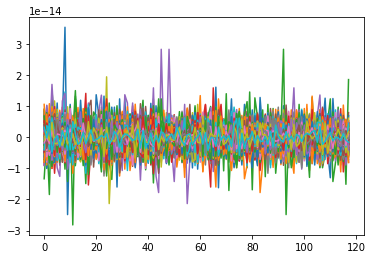

In [42]:
T     = np.array([t for t in spatiotemp_mesh]) # 
V_app = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) # TO reconstruct the signal

for k in range(process_sample.getSize()): 
    res = process_sample[k].getValues() - V_app .getMarginal(k)(T)
    plt.plot (res)

In [44]:
process_sample.getSize()

800

### <font color='green'> Etape 2: PCA - erreur de troncature</font>

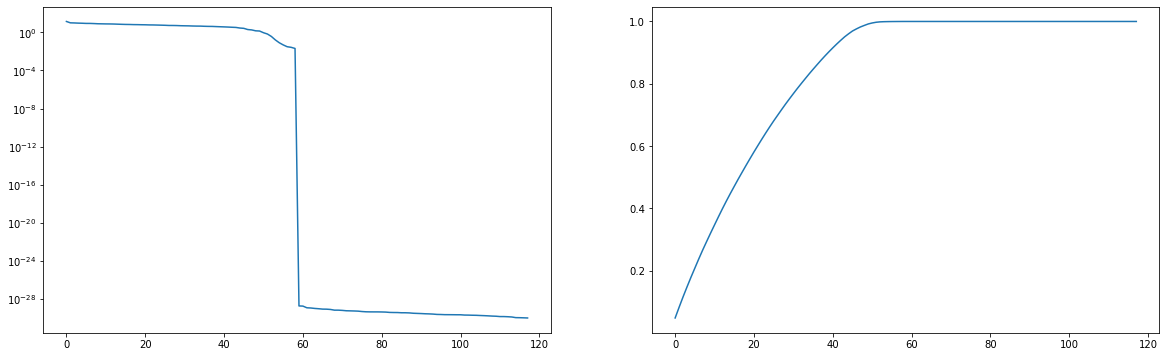

In [43]:
vp      = fPCA.getEigenValues() #  getEigenValues method enables to obtain the K first eigenvalues of the Karhunen Loeve decomposition
pVar    = np.cumsum(vp) / np.sum(vp)
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].semilogy(vp)
ax[1].plot (pVar)

## <font color='blue'> La détection d'anomalies </font>

In [31]:
#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Anomalies =[]
for i in range (nSample-1):
    if (dist.computePDF(Xi[i,:nModes]) == R.min()):
        Anomalies.append(i)
print (Anomalies)

[194, 2731, 2750, 2752, 2758, 2771, 2774, 2777, 2793, 2798]


In [32]:
nSample

3200

### <font color='green'> Minimum Level Set </font>

On prend 2 modes (c'est plus facile pour visualiser), et on cherche la ligne de niveau qui minimise la surface sur le plan $\xi [0]$ x $\xi [1]$.

Ensuite on peut tester sur pour un signal donné, sa projection sur les 2 axes principaux est à l'intérieur ou à l'extérieur de cette surface.

 Nb Outlier =  0


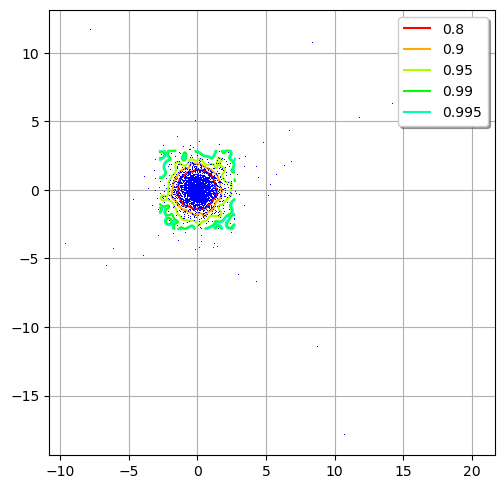

In [33]:
import openturns.viewer as otv 

#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Xin = {}; Xout = {};
Inside = []; Outside = []
ot.ResourceMap.SetAsUnsignedInteger("Distribution-MinimumVolumeLevelSetSamplingSize", 10000)
palette = ot.Contour.BuildDefaultPalette(8)
graph = ot.Graph("","","", True, "topright")
contour = dist.drawPDF().getDrawable(0)
for k, u in enumerate( [.8, .9, .95, .99, .995]):

    l, t = dist.computeMinimumVolumeLevelSetWithThreshold(u)
    contour.setLevels([t])
    contour.setColor(palette[k])
    contour.setLegend(str(u))
    graph.add(contour)
Xin = ot.Sample(0,nModes)
Xout = ot.Sample(0,nModes)
for i in range(Xi.getSize()):
    x = Xi[i][0:nModes]
    if l.contains(x): 
        Xin.add (x)
        Inside.append (i)
    else:
        Xout.add(x)
        Outside.append (i)

cloud = ot.Cloud(Xin)
cloud.setPointStyle('dot')
cloud.setColor('blue')
graph.add(cloud)
view = otv.View(graph, (800, 600), square_axes=True)
print (" Nb Outlier = ", len (Xout))

In [54]:
# What are these anomalies? Does it correspond to the event? 

(224, 1)

## <font color='blue'> Spatio-temporal maps </font>

In [ ]:
T     = np.array([t for t in spatiotemp_mesh]) # 
V_app = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) # TO reconstruct the signal 

for k in range(process_sample.getSize()): 
    V_app .getMarginal(k)(T) # is the simulated spatio temporal data
    #res = process_sample[k].getValues() - V_app .getMarginal(k)(T)
    #plt.plot (res)

In [115]:
len( fPCA.getModes())

223

In [116]:
#Avec 2 modes
nModes = 223
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

In [136]:
sample_size = 224
sample_spatio_temp_eeg = dist.getSample(sample_size)

In [137]:
XiLambda_s = sample_spatio_temp_eeg * ot.Point([np.sqrt(x) for x in fPCA.getEigenValues()])

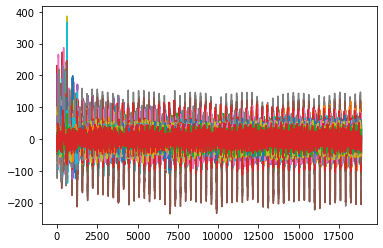

In [139]:
T     = np.array([t for t in spatiotemp_mesh]) # 
V_app = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda_s).T) # TO reconstruct the signal

for k in range(process_sample.getSize()): 
    res = V_app .getMarginal(k)(T)
    plt.plot (res)

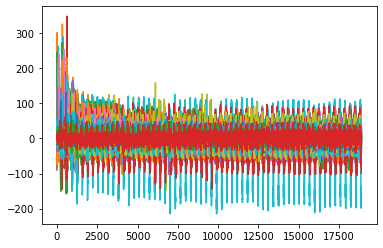

In [140]:
T     = np.array([t for t in spatiotemp_mesh]) # 
V_app = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) # TO reconstruct the signal

for k in range(process_sample.getSize()): 
    res = process_sample[k].getValues() 
    plt.plot (res)

In [ ]:
# Start with a map from the data, then from simulated?


In [18]:
NPeeg_nn_channel.shape

(13216, 320)

In [ ]:
# ot.ResourceMap.SetAsUnsignedInteger("Distribution-MinimumVolumeLevelSetSamplingSize", 10000) # what is this?

In [47]:
max_value_temporal = np.asarray(df_eeg_events.max(1)).reshape(224,59).mean(0)
max_std_temporal = np.asarray(df_eeg_events.max(1)).reshape(224,59).std(0)

In [48]:
channels_eeg = np.arange(61)
channels_eeg = np.delete(channels_eeg, [0, 5])
x_pos = x_pos_allChannels[0][channels_eeg]
y_pos = y_pos_allChannels[0][channels_eeg]

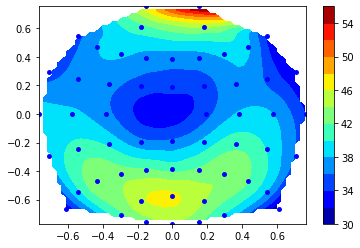

In [49]:
from scipy.interpolate import griddata
xi = np.linspace(-2,6,300);
yi = np.linspace(-2,6,300);
zi = griddata((x_pos, y_pos), max_value_temporal, (xi[None,:], yi[:,None]), method='cubic')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.colorbar()
plt.scatter(x_pos,y_pos,marker='o',c='b',s=15)
plt.xlim(min(x_pos),max(x_pos))
plt.ylim(min(y_pos),max(y_pos))

plt.show()

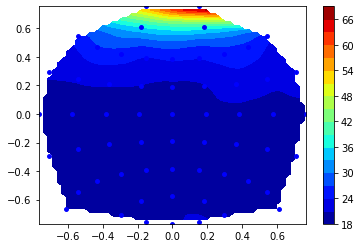

In [50]:
xi = np.linspace(-2,6,300);
yi = np.linspace(-2,6,300);
zi = griddata((x_pos, y_pos), max_std_temporal, (xi[None,:], yi[:,None]), method='cubic')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.colorbar()
plt.scatter(x_pos,y_pos,marker='o',c='b',s=15)
plt.xlim(min(x_pos),max(x_pos))
plt.ylim(min(y_pos),max(y_pos))

plt.show()

In [73]:
# Here - DO max_value_temporal for different intervals , start with before, around and after the event
# when is the event? I know the segments are center around the event 
max_value_interval = np.asarray(df_eeg_events).reshape(13216*4,80).max(1).reshape(13216,4).reshape(224,59*4).mean(0).reshape(59,4)

In [77]:
max_value_interval.shape

(59, 4)

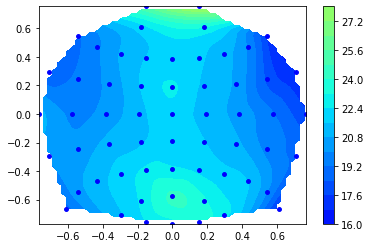

In [113]:
xi = np.linspace(-2,6,300);
yi = np.linspace(-2,6,300);
zi = griddata((x_pos, y_pos), max_value_interval[:,0], (xi[None,:], yi[:,None]), method='cubic')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.clim(vmin=12, vmax=42)
plt.colorbar()
plt.scatter(x_pos,y_pos,marker='o',c='b',s=15)
plt.xlim(min(x_pos),max(x_pos))
plt.ylim(min(y_pos),max(y_pos))

plt.show()

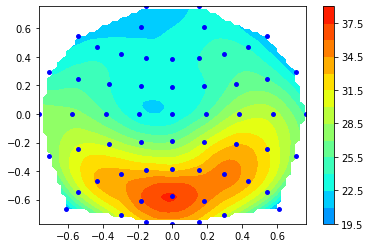

In [106]:
xi = np.linspace(-2,6,300);
yi = np.linspace(-2,6,300);
zi = griddata((x_pos, y_pos), max_value_interval[:,1], (xi[None,:], yi[:,None]), method='cubic')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet, vmin=12, vmax=42)
plt.colorbar()
plt.scatter(x_pos,y_pos,marker='o',c='b',s=15)
plt.xlim(min(x_pos),max(x_pos))
plt.ylim(min(y_pos),max(y_pos))

plt.show()

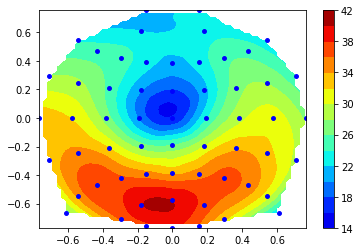

In [107]:
xi = np.linspace(-2,6,300);
yi = np.linspace(-2,6,300);
zi = griddata((x_pos, y_pos), max_value_interval[:,2], (xi[None,:], yi[:,None]), method='cubic')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet, vmin=12, vmax=42)
plt.colorbar()
plt.scatter(x_pos,y_pos,marker='o',c='b',s=15)
plt.xlim(min(x_pos),max(x_pos))
plt.ylim(min(y_pos),max(y_pos))

plt.show()

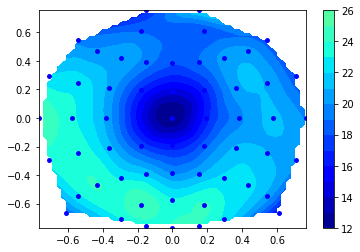

In [108]:
xi = np.linspace(-2,6,300);
yi = np.linspace(-2,6,300);
zi = griddata((x_pos, y_pos), max_value_interval[:,3], (xi[None,:], yi[:,None]), method='cubic')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet, vmin=12, vmax=42)
plt.colorbar()
plt.scatter(x_pos,y_pos,marker='o',c='b',s=15)
plt.xlim(min(x_pos),max(x_pos))
plt.ylim(min(y_pos),max(y_pos))

plt.show()

In [76]:
max_value_interval.shape

(59, 4)

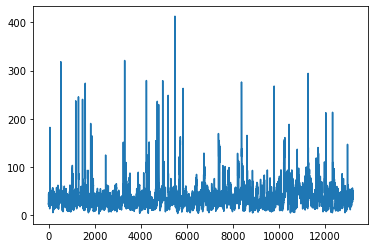

In [22]:
plt.plot(df_eeg_events.max(1))

## <font color='blue'> Non-events </font>

In [ ]:
# DO not run
import os
path_to_data = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/VPja_All_noevnets'))
files = sorted([elt for elt in os.listdir(path_to_data) if elt[-4:] == '.npy'],
                   key=(lambda x: int(x.split('_')[2])))

df_eeg = pd.DataFrame([])
for num, file in enumerate(files): # create a pandas df with 
    df_interval = pd.DataFrame(data = np.load(os.path.join(path_to_data,file)))
    outliers = np.unique(np.where(np.asarray(df_interval)>2000)[0])
    if len(outliers) == 0:
        df_eeg = df_eeg.append(df_interval)
    else:
        print(num)
df_eeg.to_csv(r'df_eeg_VPja_all_noevnets.csv', index = False)
print(df_eeg.shape)

In [ ]:
#df_eeg_Big= df_eeg
test_id = "VPja.mat" # Not used here
df_eeg_file = 'df_eeg_all.csv' # 'df_eeg_balanced.csv'Corresponds to VPja
#Lecture
df_eeg = pd.read_csv( df_eeg_file )

In [ ]:
df_eeg = np.asarray(df_eeg_Big)[59*224:59*500,]

In [ ]:
plt.plot(df_eeg[50,:])

In [ ]:
plt.plot(np.asarray(df_eeg_events)[50,:])

In [ ]:
# -> now: Take nn_channels channels
time_int = 320 #227
nn_channels = 59
NPeeg_nn_channel = []
nSample = int(df_eeg.shape[0]/59)
for i in range(nSample):
    for k in range(nn_channels):
        NPeeg_nn_channel.append(np.asarray(df_eeg)[i * 59 + k,:time_int])
NPeeg_nn_channel = np.asarray(NPeeg_nn_channel)
NPeegC = NPeeg_nn_channel-NPeeg_nn_channel.mean(axis=1).reshape(-1,1) # Pour qu'ils soient comparables
print(NPeegC.shape)

In [ ]:
mu_t = []
x = np.arange(0, NPeegC.shape[0])
for k in range(nn_channels):
    n= x[(x % nn_channels == k) ] 
    mu_t.append(NPeegC[n,:].mean(axis=0)) 
mu_t = np.array(mu_t)

In [ ]:
# Transforming my EEG into the format of the mesh - each entry must correspond 
# nn_channels = 2 # 59 1 #It is already set above 
values = []
nSample = int(df_eeg.shape[0]/59)
for k in range(nSample):
    start = k * nn_channels
    end = start + nn_channels
    values.append( (NPeegC[start:end,:] - mu_t).T) # To resemble more

In [ ]:
# OpenTurns:
import openturns as ot
num_f = 224
dim_ch_in = 1 # corresponds to process_sample
dim_ch_out = 1 # corresponds to  field
process_sample = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), num_f, dim_ch_in) 
field          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) #le 1 correspond a la dimension du champ en sortie
for k in range(process_sample.getSize()):
    aux = []
    for j in range(nn_channels):
        aux.append(values[k][:,j])
    field.setValues(np.array(aux).reshape(-1,1))
    process_sample[k] = field

In [ ]:
for k in range(process_sample.getSize()):
    aux = []
    for j in range(nn_channels):
        aux.append(values[k][:,j])
    field.setValues(np.array(aux).reshape(-1,1))
    process_sample[k] = field

In [ ]:
Xi  = fPCA.project(process_sample)

In [ ]:
Xi

In [ ]:
#Avec 2 modes
nModes = 2
X      = Xi.getMarginal ([k for k in range (nModes)])
dist   = ot.KernelSmoothing().build(X)
R      = np.array(dist.computePDF(Xi[:,:nModes]))

Xin = {}; Xout = {};
Inside = []; Outside = []
ot.ResourceMap.SetAsUnsignedInteger("Distribution-MinimumVolumeLevelSetSamplingSize", 10000)
palette = ot.Contour.BuildDefaultPalette(8)
graph = ot.Graph("","","", True, "topright")
contour = dist.drawPDF().getDrawable(0)
for k, u in enumerate( [.8, .9, .95, .99, .995]):

    l, t = dist.computeMinimumVolumeLevelSetWithThreshold(u)
    contour.setLevels([t])
    contour.setColor(palette[k])
    contour.setLegend(str(u))
    graph.add(contour)
Xin = ot.Sample(0,nModes)
Xout = ot.Sample(0,nModes)
for i in range(Xi.getSize()):
    x = Xi[i][0:nModes]
    if l.contains(x): 
        Xin.add (x)
        Inside.append (i)
    else:
        Xout.add(x)
        Outside.append (i)

cloud = ot.Cloud(Xin)
cloud.setPointStyle('dot')
cloud.setColor('blue')
graph.add(cloud)


cloud2 = ot.Cloud(Xout)
cloud2.setPointStyle('dot')
cloud2.setColor('red')
graph.add(cloud2)
view = otv.View(graph, (800, 600), square_axes=True)
print (" Nb Outlier = ", len (Xout))